In [59]:
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
# тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
# для таймера
import time
import sklearn.linear_model as skl_lm
# расчёт MSE
from sklearn.metrics import mean_squared_error
# кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score

In [61]:
my_seed = 9212
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html

# Загружаем данные

In [3]:
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/Boston_for_lab.csv'
DF_raw = pd.read_csv(fileURL)
print(DF_raw.shape)

(506, 15)


In [4]:
DF_raw.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,tax_over_400
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0


In [5]:
DF_raw.dtypes

crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rm              float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
black           float64
lstat           float64
medv            float64
tax_over_400      int64
dtype: object

In [60]:
DF_raw.isna().sum()


crim            0
zn              0
indus           0
chas            0
nox             0
rm              0
age             0
dis             0
rad             0
tax             0
ptratio         0
black           0
lstat           0
medv            0
tax_over_400    0
dtype: int64

In [7]:
DF_all = DF_raw[['medv', 'rm', 'indus', 'tax_over_400']]
DF_all.head(5)

,medv,rm,indus,tax_over_400
0,24.0,6.575,2.31,0
1,21.6,6.421,7.07,0
2,34.7,7.185,7.07,0
3,33.4,6.998,2.18,0
4,36.2,7.147,2.18,0


In [8]:
DF = DF_all.sample(frac = 0.8, random_state = my_seed)
DF_predict = DF_all.drop(DF.index)

# Предварительный анализ данных
## Считаем описательные статистики

In [9]:
DF[['medv', 'rm', 'indus']].describe()

,medv,rm,indus
count,405.000000,405.000000,405.000000
mean,22.506173,6.264746,11.114568
std,9.192299,0.712511,6.724333
min,5.000000,3.561000,0.460000
25%,17.200000,5.875000,5.320000
50%,21.000000,6.167000,9.690000
75%,25.000000,6.606000,18.100000
max,50.000000,8.780000,27.740000


## Строим графики

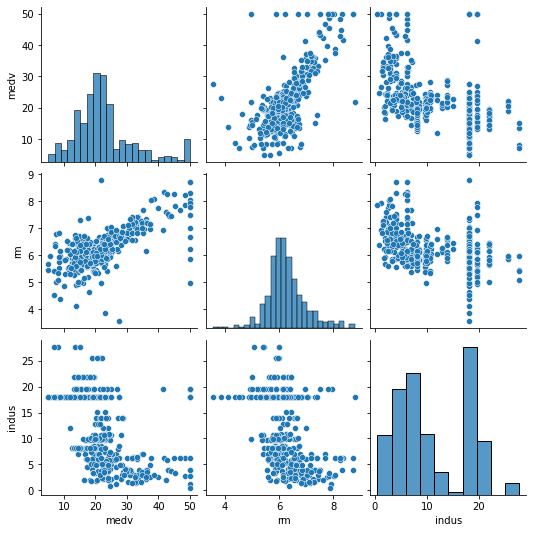

In [10]:
sns.pairplot(DF[['medv', 'rm', 'indus']])
plt.show()

## Находим корреляционные матрицы

In [11]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['medv', 'rm', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,rm,indus
medv,1.00,0.68,-0.45
rm,0.68,1.00,-0.38
indus,-0.45,-0.38,1.00


In [12]:
# корреляционная матрица по принадлежности к классу
corr_mat = DF.loc[DF['tax_over_400'] == 1][['medv', 'rm', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,rm,indus
medv,1.00,0.33,-0.10
rm,0.33,1.00,-0.11
indus,-0.10,-0.11,1.00


In [13]:
# корреляционная матрица по не принадлежности к классу
corr_mat = DF.loc[DF['tax_over_400'] == 0][['medv', 'rm', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,medv,rm,indus
medv,1.00,0.90,-0.39
rm,0.90,1.00,-0.39
indus,-0.39,-0.39,1.00


In [14]:
# тестируем на нормальность
for col in ['medv']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')
#распределение не является нормальным

medv Statistics=0.91, p=0.0000
Распределение не нормально (H0 отклоняется)



In [15]:
# тестируем на нормальность после логарифмирования
DF['log_medv'] = np.log(DF['medv'])
for col in ['log_medv']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')
# распределение не является нормальным

log_medv Statistics=0.97, p=0.0000
Распределение не нормально (H0 отклоняется)



In [16]:
DF[['medv', 'log_medv', 'rm', 'indus']].describe()

,medv,log_medv,rm,indus
count,405.000000,405.000000,405.000000,405.000000
mean,22.506173,3.034439,6.264746,11.114568
std,9.192299,0.405088,0.712511,6.724333
min,5.000000,1.609438,3.561000,0.460000
25%,17.200000,2.844909,5.875000,5.320000
50%,21.000000,3.044522,6.167000,9.690000
75%,25.000000,3.218876,6.606000,18.100000
max,50.000000,3.912023,8.780000,27.740000


In [17]:
# Далее проделываем такие же действия после логорифимирования
corr_mat = DF.loc[DF['tax_over_400'] == 1][['log_medv', 'rm', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_medv,rm,indus
log_medv,1.00,0.32,-0.16
rm,0.32,1.00,-0.11
indus,-0.16,-0.11,1.00


In [18]:
corr_mat = DF.loc[DF['tax_over_400'] == 0][['log_medv', 'rm', 'indus']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_medv,rm,indus
log_medv,1.00,0.87,-0.39
rm,0.87,1.00,-0.39
indus,-0.39,-0.39,1.00


# Построение моделей регрессии
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:
1. fit_lm_1: medv =  ^β0 + ^β1 ⋅ tax_over_400 + ^β2 ⋅ rm + ^β3 ⋅ indus
2. fit_lm_2: medv =  ^β0 + ^β1 ⋅ tax_over_400 + ^β2 ⋅ rm ⋅ tax_over_400 + ^β3 ⋅ indus
3. fit_lm_3: medv =  ^β0 + ^β1 ⋅ tax_over_400 + ^β2 ⋅ indus ⋅ tax_over_400 + ^β3 ⋅ rm
4. fit_lm_4: medv =  ^β0 + ^β1 ⋅ tax_over_400 + ^β2 ⋅ indus ⋅ tax_over_400 + ^β3 ⋅ rm ⋅ tax_over_400
5. fit_lm_1_log: то же, что fit_lm_1, но для зависимой log_charges
6. fit_lm_2_log: то же, что fit_lm_2, но для зависимой log_charges
7. fit_lm_3_log: то же, что fit_lm_3, но для зависимой log_charges
8. fit_lm_4_log: то же, что fit_lm_4, но для зависимой log_charges

## Обучение и интерпретация

In [19]:
# Создаем матрицы значений объясняющих переменных (X) и вектора значений зависимой для всех моделей


In [20]:


df1 = DF[['medv', 'rm', 'indus', 'tax_over_400']]

df2 = DF[['medv', 'rm', 'indus', 'tax_over_400']]
df2.loc[:, 'rm_tax_over_400'] = df2.loc[:, 'rm'] * df2.loc[:, 'tax_over_400']
df2 = df2.drop(['rm'], axis = 1)

df3 = DF[['medv', 'rm', 'indus', 'tax_over_400']]
df3.loc[:, 'indus_tax_over_400'] = df3.loc[:, 'indus'] * df3.loc[:, 'tax_over_400']
df3 = df3.drop(['indus'], axis = 1)

df4 = DF[['medv', 'rm', 'indus', 'tax_over_400']]
df4.loc[:, 'indus_tax_over_400'] = df4.loc[:, 'indus'] * df4.loc[:, 'tax_over_400']
df4.loc[:, 'rm_tax_over_400'] = df4.loc[:, 'rm'] * df4.loc[:, 'tax_over_400']
df4 = df4.drop(['indus', 'rm'], axis = 1)

df1.head(5)


,medv,rm,indus,tax_over_400
105,19.5,5.851,8.56,0
26,16.6,5.813,8.14,0
180,39.8,7.765,2.46,0
46,20.0,5.786,6.91,0
76,20.0,6.279,12.83,0


In [21]:
# построим модели от всех объясняющих переменных на всех наблюдениях DF, чтобы проинтерпретировать параметры. В модели для зависимой переменной charges интерпретация стандартная


In [22]:
# модель 1
lm = skl_lm.LinearRegression()
x = df1.drop(['medv'], axis = 1)
y = df1.medv.values.reshape(-1, 1)
fit_lm_1 = lm.fit(x, y)
print('модель fit_lm_1:\n',
'константа ', np.around(fit_lm_1.intercept_, 3),
'\n объясняющие ', list(x.columns.values),
'\n коэффициенты ', np.around(fit_lm_1.coef_, 3))

модель fit_lm_1:
 константа  [-23.188] 
 объясняющие  ['rm', 'indus', 'tax_over_400'] 
 коэффициенты  [[ 7.76  -0.193 -1.957]]


In [23]:
y_pred = fit_lm_1.predict(x)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
MSE

array([40.82802326])

In [24]:
# модель 2
lm = skl_lm.LinearRegression()
x = df2.drop(['medv'], axis = 1)
y = df2.medv.values.reshape(-1, 1)
fit_lm_2 = lm.fit(x, y)
print('модель fit_lm_2:\n',
'константа ', np.around(fit_lm_2.intercept_, 3),
'\n объясняющие ', list(x.columns.values),
'\n коэффициенты ', np.around(fit_lm_2.coef_, 3))

модель fit_lm_2:
 константа  [28.882] 
 объясняющие  ['indus', 'tax_over_400', 'rm_tax_over_400'] 
 коэффициенты  [[ -0.519 -25.126   3.917]]


In [25]:
y_pred = fit_lm_2.predict(x)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
MSE

array([63.96606649])

In [26]:
# модель 3 
lm = skl_lm.LinearRegression()
x = df3.drop(['medv'], axis = 1)
y = df3.medv.values.reshape(-1, 1)
fit_lm_3 = lm.fit(x, y)
print('модель fit_lm_3:\n',
'константа ', np.around(fit_lm_3.intercept_, 3),
'\n объясняющие ', list(x.columns.values),
'\n коэффициенты ', np.around(fit_lm_3.coef_, 3))

модель fit_lm_3:
 константа  [-26.426] 
 объясняющие  ['rm', 'tax_over_400', 'indus_tax_over_400'] 
 коэффициенты  [[ 8.058 -2.695 -0.071]]


In [27]:
y_pred = fit_lm_3.predict(x)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
MSE

array([41.3724093])

In [28]:
# модель 4 
lm = skl_lm.LinearRegression()
x = df4.drop(['medv'], axis = 1)
y = df4.medv.values.reshape(-1, 1)
fit_lm_4 = lm.fit(x, y)
print('модель fit_lm_3:\n',
'константа ', np.around(fit_lm_4.intercept_, 3),
'\n объясняющие ', list(x.columns.values),
'\n коэффициенты ', np.around(fit_lm_4.coef_, 3))

модель fit_lm_3:
 константа  [25.336] 
 объясняющие  ['tax_over_400', 'indus_tax_over_400', 'rm_tax_over_400'] 
 коэффициенты  [[-29.823  -0.142   4.177]]


In [29]:
y_pred = fit_lm_4.predict(x)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
MSE

array([68.3104826])

# Модель на логорифмах
Далее построим модели на логарифмах


In [30]:
# Модель 5
x = df1.drop(['medv'], axis=1)
y = np.log(df1.medv).values.reshape(-1, 1)
fit_lm_1_log = lm.fit(x, y)
print('модель fit_lm_1_log:\n',
'константа ', np.around(fit_lm_1_log.intercept_, 3),
'\n объясняющие ', list(x.columns.values),
'\n коэффициенты ', np.around(fit_lm_1_log.coef_, 3))

модель fit_lm_1_log:
 константа  [1.414] 
 объясняющие  ['rm', 'indus', 'tax_over_400'] 
 коэффициенты  [[ 0.287 -0.01  -0.163]]


In [31]:
# пересчет константы и коэффициентов для интерпритации
np.round(np.exp(fit_lm_1_log.intercept_), 1)
np.round((np.exp(fit_lm_1_log.coef_) - 1) * 100, 1)



array([[ 33.2,  -1. , -15. ]])

In [32]:
# оцениваем MSE
y_pred = fit_lm_1_log.predict(x)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
MSE_log

array([37.27490282])

In [33]:
print('MSE_train модели для medv меньше MSE_train',
'модели для log(medv) в ', np.around(MSE_log / MSE, 1), 'раз')

MSE_train модели для medv меньше MSE_train модели для log(medv) в  [0.5] раз


In [34]:
# Модель 6
x = df2.drop(['medv'], axis=1)
y = np.log(df2.medv).values.reshape(-1, 1)
fit_lm_2_log = lm.fit(x, y)
print('модель fit_lm_2_log:\n',
'константа ', np.around(fit_lm_2_log.intercept_, 3),
'\n объясняющие ', list(x.columns.values),
'\n коэффициенты ', np.around(fit_lm_2_log.coef_, 3))

модель fit_lm_2_log:
 константа  [3.338] 
 объясняющие  ['indus', 'tax_over_400', 'rm_tax_over_400'] 
 коэффициенты  [[-0.022 -1.264  0.185]]


In [35]:
np.round(np.exp(fit_lm_2_log.intercept_), 1)
np.round((np.exp(fit_lm_2_log.coef_) - 1) * 100, 1)

array([[ -2.2, -71.8,  20.3]])

In [36]:
y_pred = fit_lm_2_log.predict(x)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
MSE_log


array([64.40697984])

In [37]:
print('MSE_train модели для medv меньше MSE_train',
'модели для log(medv) в ', np.around(MSE_log / MSE, 1), 'раз')

MSE_train модели для medv меньше MSE_train модели для log(medv) в  [0.9] раз


In [38]:
# Модель 7
x = df3.drop(['medv'], axis=1)
y = np.log(df3.medv).values.reshape(-1, 1)
fit_lm_3_log = lm.fit(x, y)
print('модель fit_lm3_log:\n',
'константа ', np.around(fit_lm_3_log.intercept_, 3),
'\n объясняющие ', list(x.columns.values),
'\n коэффициенты ', np.around(fit_lm_3_log.coef_, 3))

модель fit_lm3_log:
 константа  [1.255] 
 объясняющие  ['rm', 'tax_over_400', 'indus_tax_over_400'] 
 коэффициенты  [[ 0.301 -0.075 -0.011]]


In [39]:
np.round(np.exp(fit_lm_3_log.intercept_), 1)
np.round((np.exp(fit_lm_3_log.coef_) - 1) * 100, 1)

array([[35.1, -7.2, -1.1]])

In [40]:
y_pred = fit_lm_3_log.predict(x)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
MSE_log


array([37.82146506])

In [41]:
print('MSE_train модели для medv меньше MSE_train',
'модели для log(medv) в ', np.around(MSE_log / MSE, 1), 'раз')

MSE_train модели для medv меньше MSE_train модели для log(medv) в  [0.6] раз


In [42]:
# Модель 8
x = df4.drop(['medv'], axis=1)
y = np.log(df4.medv).values.reshape(-1, 1)
fit_lm_4_log = lm.fit(x, y)
print('модель fit_lm3_log:\n',
'константа ', np.around(fit_lm_4_log.intercept_, 3),
'\n объясняющие ', list(x.columns.values),
'\n коэффициенты ', np.around(fit_lm_4_log.coef_, 3))

модель fit_lm3_log:
 константа  [3.188] 
 объясняющие  ['tax_over_400', 'indus_tax_over_400', 'rm_tax_over_400'] 
 коэффициенты  [[-1.311 -0.013  0.191]]


In [43]:
np.round(np.exp(fit_lm_4_log.intercept_), 1)
np.round((np.exp(fit_lm_4_log.coef_) - 1) * 100, 1)

array([[-73.1,  -1.3,  21.1]])

In [44]:
y_pred = fit_lm_4_log.predict(x)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
MSE_log


array([69.76254812])

In [45]:
print('MSE_train модели для medv меньше MSE_train',
'модели для log(medv) в ', np.around(MSE_log / MSE, 1), 'раз')

MSE_train модели для medv меньше MSE_train модели для log(medv) в  [1.] раз


# Оценка точности
## LOOCV
Сделаем перекрёстную проверку точности моделей по одному наблюдению.

In [46]:
# модели для y
# LeaveOneOut CV
loo = LeaveOneOut()
# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df1, df2, df3, df4] :
    loo.get_n_splits(df)
    x = df.drop(['medv'], axis=1)
    y = df.medv
    score = cross_val_score(lm, x, y, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)
# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 4.30 секунд


In [47]:
# модели для y_log
scores_log = list()
# таймер
tic = time.perf_counter()
for df in [df1, df2, df3, df4] :
    loo.get_n_splits(df)
    x = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    score = cross_val_score(lm, x, y, cv=loo, n_jobs=1, scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 4.30 секунд


Сравним ошибки для моделей на исходных значениях, с ошибками моделей на логарифме

In [48]:
[np.around(-x,2) for x in scores]

[42.01, 65.8, 42.53, 70.07]

In [49]:
[np.around(-x, 3) for x in scores_log]

[0.085, 0.115, 0.085, 0.122]

Очевидно что данные оценки между собой сравнивать нельзя, тогда проведем процедуру оценки на логарифме и без него

In [50]:
# без логарифма
fits = ['fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели', fits[scores.index(max(scores))], ':\nMSE_loocv =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_1 :
MSE_loocv = 42.0


In [51]:
# с логарифмом
fits = ['fit_lm_1_log', 'fit_lm_2_log',
'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
fits[scores_log.index(max(scores_log))],
':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_1_log :
MSE_loocv = 0.085


Перекрёстная проверка по блокам

In [52]:
# Перекрёстная проверка по 10 блокам
folds = 10
# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)
# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df1, df2, df3, df4] :
    x = df.drop(['medv'], axis=1)
    y = df.medv
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
        shuffle=True)
    score = cross_val_score(lm, x, y, cv=kf_10,
            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1
# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.12 секунд


In [53]:
# Перекрёстная проверка по 10 блокам
folds = 10
# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)
# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df1, df2, df3, df4] :
    x = df.drop(['medv'], axis=1)
    y = df.medv
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
        shuffle=True)
    score = cross_val_score(lm, x, y, cv=kf_10,
            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1
# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.11 секунд


In [54]:
# самая точная на charges
fits = ['fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
fits[scores.index(max(scores))],
':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_1 :
MSE_kf10 = 42.0


In [55]:
# самая точная на log(charges)
fits = ['fit_lm_1_log', 'fit_lm_2_log',
'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
fits[scores_log.index(max(scores_log))],
':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_1_log :
MSE_kf10 = 42.222


Самой точной среди моделей для medv оказалась fit_lm_1 , а среди моделей для
medv_log – fit_lm_1_log . Оценим точность прогноза по этим моделям на отложенные
наблюдения.

In [56]:
# прогноз по fit_lm_1
# модель на всех обучающих наблюдениях
x = df1.drop(['medv'], axis=1)
y = df1.medv.values.reshape(-1, 1)
fit_lm_1 = lm.fit(x, y)
# значения y на отложенных наблюдениях
y = DF_predict[['medv']].values.reshape(-1, 1)
# матрица объясняющих на отложенных наблюдениях
x = DF_predict[['rm', 'indus', 'tax_over_400']]
# прогнозы
y_pred = fit_lm_1.predict(x)
# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_1 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_1 на отложенных наблюдениях = 30.68


In [57]:
# прогноз по fit_lm_log_1
# модель на всех обучающих наблюдениях
x = df1.drop(['medv'], axis=1)
y = np.log(df1.medv).values.reshape(-1, 1)
fit_lm_1 = lm.fit(x, y)
# значения y на отложенных наблюдениях
y = DF_predict[['medv']].values.reshape(-1, 1)
# матрица объясняющих на отложенных наблюдениях
x = DF_predict[['rm', 'indus', 'tax_over_400']]
# прогнозы
y_pred = fit_lm_1.predict(x)
# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_1 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_1 на отложенных наблюдениях = 464.20


Очевидно, что самой лучшей является модель fit_lm_1
## Прогноз на отложенные наблюдения по лучшей модели



In [58]:
print('Ошибка модели на отложенных наблюдениях составила ',
np.around(np.sqrt(MSE) / np.mean(y) * 100, 1)[0],
'% от среднего значения Y',
sep='')

Ошибка модели на отложенных наблюдениях составила 95.2% от среднего значения Y


Вывод: Наилучшей моделью является fit_lm_1 
1. fit_lm_1: medv =  ^β0 + ^β1 ⋅ tax_over_400 + ^β2 ⋅ rm + ^β3 ⋅ indus